In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import random as rnd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score , mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score , mean_absolute_error

In [149]:
def generate_index(list):
    return {value: key for key, value in enumerate(list, 1)}


def dropExtraColumns(data):
    columns = data.columns
    data.drop(columns[0], axis=1, inplace=True)
    #data.drop('Temperature in Montreal during episode', axis=1, inplace=True)
    data.drop('Name of episode', axis=1, inplace=True)
    data.drop('Name of show', axis=1, inplace=True)
    data.drop('Length',axis=1,inplace=True)
    
    

def mapping(data):
    binary_map = {"Yes": 1, "No": 0}
    episode_map = generate_index(data['Episode'].unique())
    station_map = generate_index(data['Station'].unique())
    season_map = generate_index(data['Season'].unique())
    channel_map = generate_index(data['Channel Type'].unique())
    year_map = generate_index(data["Year"].unique())
    week_map = generate_index(data['Day of week'].unique())
    genre_map = generate_index(data['Genre'].unique())
    date_map = generate_index(data['Date'].unique())

    data['Station'] = data['Station'].map(station_map)
    data['Episode'] = data['Episode'].map(episode_map)
    data['Channel Type'] = data['Channel Type'].map(channel_map)
    data['Season'] = data['Season'].map(season_map)
    data['Year'] = data["Year"].map(year_map)
    data['Day of week'] = data['Day of week'].map(week_map)
    data['Genre'] = data['Genre'].map(genre_map)
    data['First time or rerun'] = data['First time or rerun'].map(binary_map)
    data['Movie?'] = data['Movie?'].map(binary_map)
    data['# of episode in the season'] = data['# of episode in the season'].map(binary_map)
    data['Game of the Canadiens during episode?'] = data['Game of the Canadiens during episode?'].map(binary_map)
    data['Date'] = data['Date'].map(date_map)
    

def processTime(data):
    data['Start_time'] = pd.to_datetime(data['Start_time'])
    data['Start_minutes'] = data['Start_time'].dt.hour * 60 + data['Start_time'].dt.minute + data[
        'Start_time'].dt.second / 60
    data['End_time'] = pd.to_datetime(data['End_time'])
    data['End_minutes'] = data['End_time'].dt.hour * 60 + data['End_time'].dt.minute + data[
        'End_time'].dt.second / 60
    data.drop('Start_time', axis=1, inplace=True)
    data.drop('End_time', axis=1, inplace=True)

In [150]:
train_df = pd.read_csv('data.csv')
train_df

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode
0,1,Vidéoclips V,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 06:00:00,2016-08-29 08:00:00,8,Vidéoclips V,NaN,Music Video Clips,No,Yes,No,No,0.9,20.400000
1,2,Apollo dans l'frigo,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:00:00,2016-08-29 08:30:00,2,Apollo dans l'frigo,NaN,Informal Education and Recreation and Leisure,No,Yes,No,No,0.5,19.125000
2,3,Infopublicité,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:30:00,2016-08-29 09:00:00,2,Infopublicité,NaN,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,0.3,19.125000
3,4,"Infos, Les",V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 09:00:00,2016-08-29 10:00:00,4,"Infos, Les",NaN,News,No,Yes,No,No,1.7,18.125000
4,5,"Souper presque parfait, Un",V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 10:00:00,2016-08-29 10:30:00,2,"Souper presque parfait, Un",NaN,Reality Programs,No,Yes,No,No,2.2,18.250000
5,6,Opération séduction,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 10:30:00,2016-08-29 11:00:00,2,Opération séduction,NaN,Reality Programs,No,Yes,No,No,2.7,18.250000
6,7,Tic tac show,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 11:00:00,2016-08-29 11:30:00,2,Tic tac show,NaN,Game Shows,No,Yes,No,No,2.3,19.200000
7,8,Révolution,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 11:30:00,2016-08-29 12:30:00,4,Révolution,NaN,Ongoing Dramatic Series,No,Yes,No,No,1.4,19.550000
8,9,CSI: Miami,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 12:30:00,2016-08-29 13:30:00,4,CSI: Miami,NaN,Ongoing Dramatic Series,No,Yes,No,No,7.5,20.437500
9,10,CSI: Miami,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 13:30:00,2016-08-29 14:30:00,4,CSI: Miami,NaN,Ongoing Dramatic Series,No,Yes,No,No,12.1,21.400000


In [151]:
dropExtraColumns(train_df)
mapping(train_df)
processTime(train_df)
train_df = train_df.dropna(axis = 0)
train_df.isnull().sum()

Episode                                   0
Station                                   0
Channel Type                              0
Season                                    0
Year                                      0
Date                                      0
Day of week                               0
Genre                                     0
First time or rerun                       0
# of episode in the season                0
Movie?                                    0
Game of the Canadiens during episode?     0
Market Share_total                        0
Temperature in Montreal during episode    0
Start_minutes                             0
End_minutes                               0
dtype: int64

In [152]:
train_df

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode,Start_minutes,End_minutes
0,1,1,1,1,1,1,1,1,0,1,0,0,0.9,20.400000,360.0,480.0
1,2,1,1,1,1,1,1,2,0,1,0,0,0.5,19.125000,480.0,510.0
2,3,1,1,1,1,1,1,3,0,1,0,0,0.3,19.125000,510.0,540.0
3,4,1,1,1,1,1,1,4,0,1,0,0,1.7,18.125000,540.0,600.0
4,5,1,1,1,1,1,1,5,0,1,0,0,2.2,18.250000,600.0,630.0
5,6,1,1,1,1,1,1,5,0,1,0,0,2.7,18.250000,630.0,660.0
6,7,1,1,1,1,1,1,6,0,1,0,0,2.3,19.200000,660.0,690.0
7,8,1,1,1,1,1,1,7,0,1,0,0,1.4,19.550000,690.0,750.0
8,9,1,1,1,1,1,1,7,0,1,0,0,7.5,20.437500,750.0,810.0
9,9,1,1,1,1,1,1,7,0,1,0,0,12.1,21.400000,810.0,870.0


__Trying Different Models__

here i will train and test some different models then i'll compare the
r2score and mae to choose the best for predicting test data.

i'll choose 70 percent of train set to train the models and the rest 30 percent to test the trained model on.

In [153]:
y = train_df["Market Share_total"]
x = train_df.drop('Market Share_total', axis = 1)

In [154]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

__DecisionTreeRegressor__

In [155]:
predictor = DecisionTreeRegressor(max_depth = 50)
predictor.fit(x_train,y_train)
y_predicted = predictor.predict(x_test )
print("r2: " ,r2_score(y_test , y_predicted))
print("mae: ",mean_absolute_error(y_test,y_predicted))

r2:  0.8334380565606248
mae:  1.156659937247647


In [156]:
cv_score = cross_val_score( predictor, x_train , y_train, cv=5,scoring='r2')
print("cv_score mean " , np.mean(cv_score))
print("cv_score std ",np.std(cv_score))

cv_score mean  0.8253334144772886
cv_score std  0.0037714327198385884


__Gradient boost__


In [157]:
import xgboost as xgb
params = {'eval_metric':'rmse'}
xm = xgb.DMatrix(x_train, label=y_train)
xmodel = xgb.train(params, xm)
y_predicted = xmodel.predict(xgb.DMatrix(x_test))
print("r2: " ,r2_score(y_test , y_predicted))
print("mae ",mean_absolute_error(y_test,y_predicted))

c:\users\parastoo\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


r2:  0.8313600277367006
mae  1.2435664006187324


__AdaBoostRegressor__

In [158]:
# from sklearn.ensemble import AdaBoostRegressor
# predictor = AdaBoostRegressor( DecisionTreeRegressor(max_depth=50))
# predictor.fit(x_train,y_train)
# y_predicted = predictor.predict(x_test)
# print("r2: " ,r2_score(y_test , y_predicted))
# print("mae ",mean_absolute_error(y_test,y_predicted))

__RandomForestRegressor__

In [159]:
from sklearn.ensemble import RandomForestRegressor
predictor = RandomForestRegressor(n_estimators=10)
predictor.fit(x_train,y_train)
y_predicted = predictor.predict(x_test )
print("r2: " ,r2_score(y_test , y_predicted))
print("mae: ",mean_absolute_error(y_test,y_predicted))

r2:  0.9011124042173081
mae:  0.9242835981349298


SO it appears that __RandomForestRegressor__ is the best
here i'm gonna plot both __predicted y__ and the __actual y__ from some random portion of the data

In [130]:
x_test['id']  = range( 1, len(x_test) +1) #adding id column to x_test

c:\users\parastoo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


c:\users\parastoo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


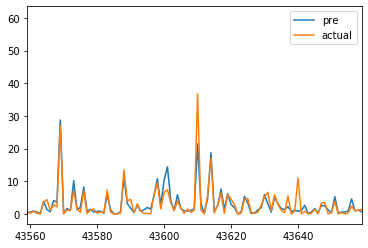

In [131]:
fig, ax = plt.subplots()
ax.plot(x_test['id'].tolist(), y_predicted, label="pre")
ax.plot(x_test['id'].tolist(), y_test, label="actual")
ax.legend()

randomStartIndex = rnd.randrange(1,len(x_test) - 101)
plt.xlim(randomStartIndex, randomStartIndex + 100 )
plt.show()

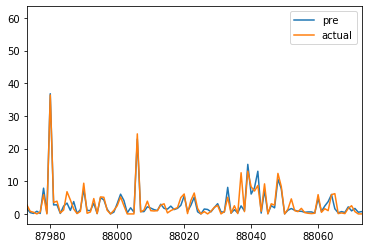

In [132]:
fig, ax = plt.subplots()
ax.plot(x_test['id'].tolist(), y_predicted, label="pre")
ax.plot(x_test['id'].tolist(), y_test, label="actual")
ax.legend()

randomStartIndex = rnd.randrange(1,len(x_test) - 101)
plt.xlim(randomStartIndex, randomStartIndex + 100 )
plt.show()

so as we can see in the plots , the prediction is very close to the actual data


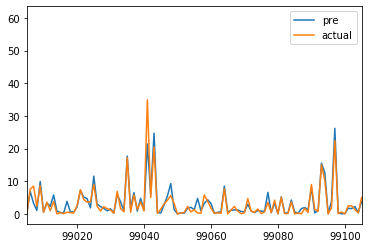

In [133]:
fig, ax = plt.subplots()
ax.plot(x_test['id'].tolist(), y_predicted, label="pre")
ax.plot(x_test['id'].tolist(), y_test, label="actual")
ax.legend()

randomStartIndex = rnd.randrange(1,len(x_test) - 101)
plt.xlim(randomStartIndex, randomStartIndex + 100 )
plt.show()


